# Part 2: Handling Imbalanced Class

## Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier 
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.metrics import f1_score,accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, precision_recall_curve, auc
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


Bad key "text.kerning_factor" on line 4 in
C:\Users\sumai\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## Load Dataset

Please see the link to know more about the dataset: https://archive.ics.uci.edu/ml/datasets/Cervical+cancer+%28Risk+Factors%29

In [2]:
df = pd.read_csv('preprocessed_risk_factors_cervical_cancer.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,age,number_of_sexual_partners,first_sexual_intercourse,num_of_pregnancies,smokes,smokes_(years),smokes_(packs_year),hormonal_contraceptives,hormonal_contraceptives_(years),iud,...,stds_aids,stds_hiv,stds_hepatitis_b,stds_hpv,stds_number_of_diagnosis,dx_cancer,dx_cin,dx_hpv,dx,hinselmann
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0
2,34,1.0,19.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0,1,0,1,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0


In [3]:
features = df.columns.to_list()

## Split Input and Traget Variables

In [4]:
X = df.drop('hinselmann', axis = 1) 
y = df['hinselmann']

In [5]:
X.columns

Index(['age', 'number_of_sexual_partners', 'first_sexual_intercourse',
       'num_of_pregnancies', 'smokes', 'smokes_(years)', 'smokes_(packs_year)',
       'hormonal_contraceptives', 'hormonal_contraceptives_(years)', 'iud',
       'iud_(years)', 'stds', 'stds_(number)', 'stds_condylomatosis',
       'stds_cervical_condylomatosis', 'stds_vaginal_condylomatosis',
       'stds_vulvo-perineal_condylomatosis', 'stds_syphilis',
       'stds_pelvic_inflammatory_disease', 'stds_genital_herpes',
       'stds_molluscum_contagiosum', 'stds_aids', 'stds_hiv',
       'stds_hepatitis_b', 'stds_hpv', 'stds_number_of_diagnosis', 'dx_cancer',
       'dx_cin', 'dx_hpv', 'dx'],
      dtype='object')

## Train Test Split

In [6]:
# train_test_split is used to split the dataset into test set and train set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state =0)

print("Original shape of dataset: {}".format(df.shape))         # shape of original dataset
print("Shape of training dataset: {}".format(X_train.shape))      # shape of training dataset after split
print("Shape of testing dataset: {}".format(X_test.shape))        # shape of testing dataset after split

Original shape of dataset: (858, 31)
Shape of training dataset: (643, 30)
Shape of testing dataset: (215, 30)


### Defining function for later use

In [7]:
def macro_weighted(y_test, y_hat):
    
    rec = recall_score(y_test, y_hat)
    print ("Recall Score:", round(rec, 4))

    rec_mac = recall_score(y_test, y_hat, average = 'macro')
    print ("Macro Average of Recall Score:", round(rec_mac, 4))

    rec_wei = recall_score(y_test, y_hat, average = 'weighted')
    print ("Weighted Average of Recall Score:", round(rec_wei, 4))
    
    print ('------------------------------------------------------')
    
    prec_mac = precision_score(y_test, y_hat, average = 'macro')
    print ("Macro Average of Precision Score:", round(prec_mac, 4))

    prec_wei = precision_score(y_test, y_hat, average = 'weighted')
    print ("Weighted Average of Precision Score:", round(prec_wei, 4))
    
    print ('------------------------------------------------------')

    f1_mac = f1_score(y_test, y_hat, average = 'macro')
    print ("Macro Average of F1 Score:", round(f1_mac, 4))

    f1_wei = f1_score(y_test, y_hat, average = 'weighted')
    print ("Weighted Average of F1 Score:", round(f1_wei, 4))

In [8]:
def cm():
    
        print('---------------------------------------------------------------')
        
        data = confusion_matrix(y_test, y_hat)
        df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
        df_cm.index.name = 'Actual'
        df_cm.columns.name = 'Predicted'
        plt.figure(figsize = (6, 4))
        #sns.set(font_scale=1.4) #for label size
        sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 12})# font size
        plt.show()
        
        tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()
        print ("TP: {}, FP: {}, TN: {}, FN: {}".format(tp, fp, tn, fn))

In [9]:
def class_rep():
        
        # Print the precision and recall, among other metrics
        print('---------------------------------------------------------------')
        print(classification_report(y_test, y_hat, digits=3))

### Handling Imbalanced Dataset

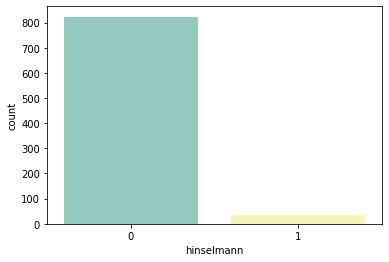

In [10]:
sns.countplot(df['hinselmann'], palette = "Set3")

#### Resampling Techniques - Oversample Minority Class

Oversampling can be defined as adding more copies of the minority class. In other words, we are creating artificial/synthetic data of the minority class (or group). Oversampling could be a good choice when you don’t have a lot of data to work with. We will use the resampling module from Scikit-Learn library to randomly create artificial samples of data from the minority class.

In [11]:
# 'resample' is located under sklearn.utils
from sklearn.utils import resample

# concatenate training data back together
train_data = pd.concat([X_train, y_train], axis = 1)

# separate minority and majority class
not_cancer = train_data[train_data['hinselmann']==0]
Cervical = train_data[train_data['hinselmann']==1]

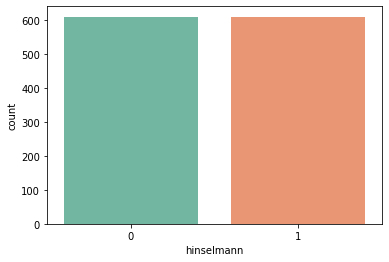

In [12]:
# Unsample minority; we are oversampling the minority class to match the number of majority classs
Cervical_oversampled = resample(Cervical,
                           replace = True, # Sample with replacement
                           n_samples = len(not_cancer), # Match number in majority class
                           random_state=27)

# combine majority and upsampled minority
oversampled = pd.concat([not_cancer, Cervical_oversampled])
sns.countplot(oversampled['hinselmann'], palette = "Set2")

Recall Score: 0.3333
Macro Average of Recall Score: 0.5605
Weighted Average of Recall Score: 0.7814
------------------------------------------------------
Macro Average of Precision Score: 0.505
Weighted Average of Precision Score: 0.9747
------------------------------------------------------
Macro Average of F1 Score: 0.4587
Weighted Average of F1 Score: 0.865
---------------------------------------------------------------


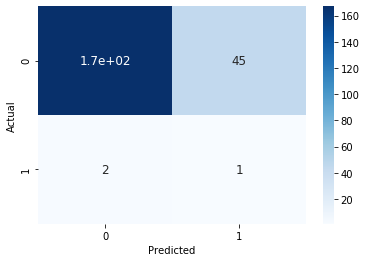

TP: 1, FP: 45, TN: 167, FN: 2
---------------------------------------------------------------
              precision    recall  f1-score   support

           0      0.988     0.788     0.877       212
           1      0.022     0.333     0.041         3

    accuracy                          0.781       215
   macro avg      0.505     0.561     0.459       215
weighted avg      0.975     0.781     0.865       215



In [13]:
X_train = oversampled.drop('hinselmann', axis = 1) 
y_train = oversampled['hinselmann']

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

model = EasyEnsembleClassifier(random_state = 25)
model.fit(X_train, y_train)
y_hat = model.predict(X_test)

macro_weighted(y_test, y_hat)
cm()
class_rep()

#### Generate Synthetic Samples: SMOTE

Here we will use imblearn’s SMOTE or Synthetic Minority Oversampling Technique. SMOTE uses a nearest neighbors algorithm to generate new and synthetic data we can use for training our model. It’s important to generate the new samples only in the training set to ensure our model generalizes well to unseen data.

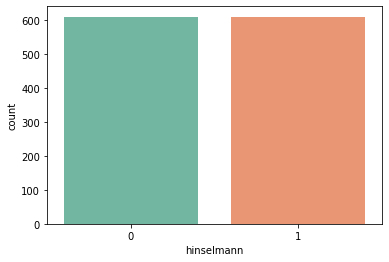

In [14]:
df = pd.read_csv('preprocessed_risk_factors_cervical_cancer.csv', usecols = features)

X = df.drop('hinselmann', axis = 1) 
y = df['hinselmann']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state =0)

# import SMOTE 
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 25, sampling_strategy='auto')   # again we are eqalizing both the classes

# fit the sampling
X_train, y_train = sm.fit_sample(X_train, y_train)
np.unique(y_train, return_counts=True)     # Y_train is numpy array, so unique() functions returns the count of all the unique elements in the array

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

sns.countplot(y_train, palette = "Set2")

Recall Score: 0.0
Macro Average of Recall Score: 0.4764
Weighted Average of Recall Score: 0.9395
------------------------------------------------------
Macro Average of Precision Score: 0.4927
Weighted Average of Precision Score: 0.9716
------------------------------------------------------
Macro Average of F1 Score: 0.4844
Weighted Average of F1 Score: 0.9553
---------------------------------------------------------------


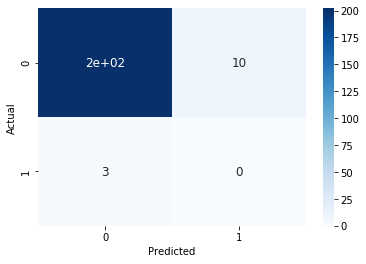

TP: 0, FP: 10, TN: 202, FN: 3
---------------------------------------------------------------
              precision    recall  f1-score   support

           0      0.985     0.953     0.969       212
           1      0.000     0.000     0.000         3

    accuracy                          0.940       215
   macro avg      0.493     0.476     0.484       215
weighted avg      0.972     0.940     0.955       215



In [15]:
model = EasyEnsembleClassifier(random_state = 25)
model.fit(X_train, y_train)
y_hat = model.predict(X_test)

macro_weighted(y_test, y_hat)
cm()
class_rep()

#### SMOTETomek

In [16]:
df = pd.read_csv('preprocessed_risk_factors_cervical_cancer.csv', usecols = features)

X = df.drop('hinselmann', axis = 1) 
y = df['hinselmann']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state =0)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

The number of classes before fit Counter({0: 611, 1: 32})
The number of classes after fit Counter({0: 605, 1: 574})


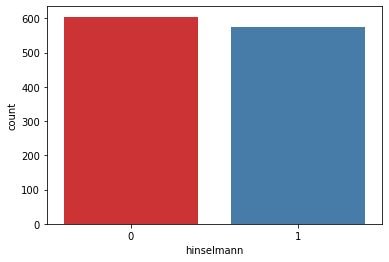

In [17]:
from imblearn.combine import SMOTETomek
from collections import Counter
smot = SMOTETomek(0.95)
X_train_ns, y_train_ns = smot.fit_sample(X_train, y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_ns)))

sns.countplot(y_train_ns, palette = "Set1")

Recall Score: 0.0
Macro Average of Recall Score: 0.4811
Weighted Average of Recall Score: 0.9488
------------------------------------------------------
Macro Average of Precision Score: 0.4928
Weighted Average of Precision Score: 0.9718
------------------------------------------------------
Macro Average of F1 Score: 0.4869
Weighted Average of F1 Score: 0.9602
---------------------------------------------------------------


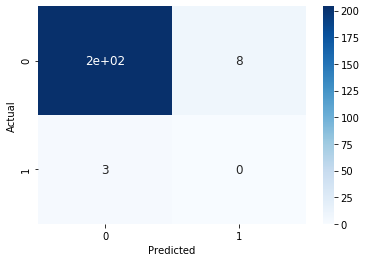

TP: 0, FP: 8, TN: 204, FN: 3
---------------------------------------------------------------
              precision    recall  f1-score   support

           0      0.986     0.962     0.974       212
           1      0.000     0.000     0.000         3

    accuracy                          0.949       215
   macro avg      0.493     0.481     0.487       215
weighted avg      0.972     0.949     0.960       215



In [18]:
model = EasyEnsembleClassifier(random_state = 25)
model.fit(X_train_ns, y_train_ns)
y_hat = model.predict(X_test)

macro_weighted(y_test, y_hat)
cm()
class_rep()

### How does the EasyEnsemble Classifier perform itself?

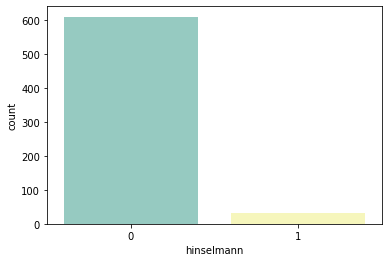

In [19]:
df = pd.read_csv('preprocessed_risk_factors_cervical_cancer.csv', usecols = features)

X = df.drop('hinselmann', axis = 1) 
y = df['hinselmann']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state =0)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

sns.countplot(y_train, palette = "Set3")

Recall Score: 1.0
Macro Average of Recall Score: 0.7783
Weighted Average of Recall Score: 0.5628
------------------------------------------------------
Macro Average of Precision Score: 0.5155
Weighted Average of Precision Score: 0.9865
------------------------------------------------------
Macro Average of F1 Score: 0.3876
Weighted Average of F1 Score: 0.706
---------------------------------------------------------------


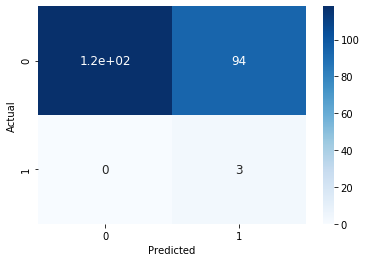

TP: 3, FP: 94, TN: 118, FN: 0
---------------------------------------------------------------
              precision    recall  f1-score   support

           0      1.000     0.557     0.715       212
           1      0.031     1.000     0.060         3

    accuracy                          0.563       215
   macro avg      0.515     0.778     0.388       215
weighted avg      0.986     0.563     0.706       215



In [20]:
model = EasyEnsembleClassifier(random_state = 25)
model.fit(X_train, y_train)
y_hat = model.predict(X_test)

macro_weighted(y_test, y_hat)
cm()
class_rep()

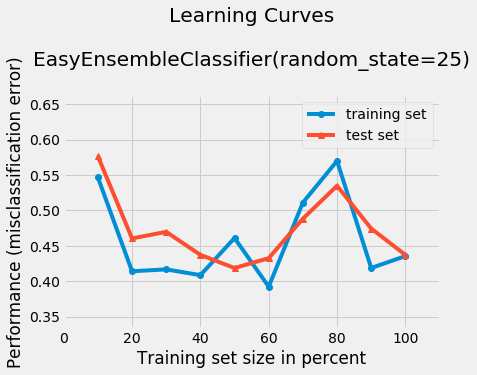

In [21]:
from mlxtend.plotting import plot_learning_curves
plot_learning_curves(X_train, y_train, X_test, y_test, model)
plt.show()

### We will not create any synthetic sample in this dataset. Instead we will use EasyEnsemble Classifier. 

##### Let's try to find the threshold that corresponds to highest f1 score and thus find the best model. Please refer to https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c.

In [22]:
# Let's change test size and see the difference
test_size = list(np.arange(0.15, 0.41, 0.01))

# Let's create a list of threshold value ranging from 0 to 1.
threshold = list(np.arange(0.0, 1, 0.039))

In [23]:
# Now, let's append the threshol and tp, tn, fp, fn values in a DataFrame

tp = []
fp = []
tn = []
fn = []
    
for tt in test_size:

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= tt, random_state =0)
    
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    
    model = EasyEnsembleClassifier(random_state = 25)
    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)
        
    tn.append(confusion_matrix(y_test, y_hat).ravel()[0]) 
    fp.append(confusion_matrix(y_test, y_hat).ravel()[1])
    fn.append(confusion_matrix(y_test, y_hat).ravel()[2])
    tp.append(confusion_matrix(y_test, y_hat).ravel()[3])
    
results = pd.DataFrame({'threshold': threshold, 'tp' : tp , 'fp': fp, 'tn': tn, 'fn': fn})
results

,threshold,tp,fp,tn,fn
0,0.000,1,47,80,1
1,0.039,2,72,64,0
2,0.078,2,66,78,0
3,0.117,2,60,93,0
4,0.156,1,63,99,1
5,0.195,2,66,104,0
6,0.234,2,84,95,0
7,0.273,2,76,111,0
8,0.312,3,93,102,0
9,0.351,3,92,111,0


In [24]:
def calculate_metrics(results):
    roc = pd.DataFrame(index = results['threshold'], columns=['recall', 'precision', 'f1', 'tpr', 'fpr'])
    
    for i in results.iterrows():
        t, tp, fp, tn, fn = i[1]
        tp + fp + tn + fn == 129
        
        recall = tp / (tp + fn)
        
        if tp == fp == 0:
            precision = 0
            true_positive_rate = 0
        
        else:
            precision = tp / (tp + fp)
            true_positive_rate = tp / (tp + fn)
            
        if precision == recall == 0:
            f1 = 0
        else:
            f1 = 2 * (precision * recall) / (precision + recall)
        
        
        false_positive_rate = fp / (fp + tn)
        
        roc.loc[t, 'recall'] = recall
        roc.loc[t, 'precision'] = precision
        roc.loc[t, 'f1'] = f1
        roc.loc[t, 'tpr'] = true_positive_rate
        roc.loc[t, 'fpr'] = false_positive_rate
    
    return roc

In [25]:
roc = calculate_metrics(results)
roc.reset_index()

,threshold,recall,precision,f1,tpr,fpr
0,0.000,0.5,0.0208333,0.04,0.5,0.370079
1,0.039,1,0.027027,0.0526316,1,0.529412
2,0.078,1,0.0294118,0.0571429,1,0.458333
3,0.117,1,0.0322581,0.0625,1,0.392157
4,0.156,0.5,0.015625,0.030303,0.5,0.388889
5,0.195,1,0.0294118,0.0571429,1,0.388235
6,0.234,1,0.0232558,0.0454545,1,0.469274
7,0.273,1,0.025641,0.05,1,0.406417
8,0.312,1,0.03125,0.0606061,1,0.476923
9,0.351,1,0.0315789,0.0612245,1,0.453202


#### Best F1 score: 0.0895522 and 0.0824742; thus, test size becomes could be either 0.34 or 0.39.
#### But we want to choose a model with smallest False Negative Rate i.e., fn = 0 where f1 = 0.0805369. Thus, test size could also be 0.32. Let's also try 0.16.
### Let's check..

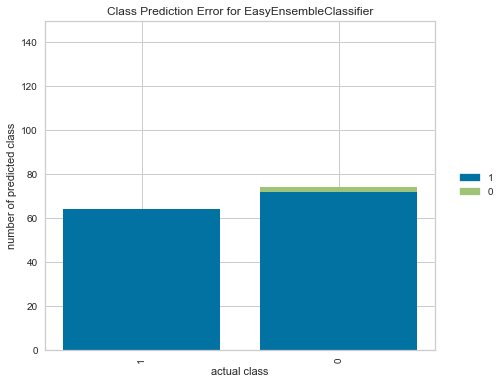

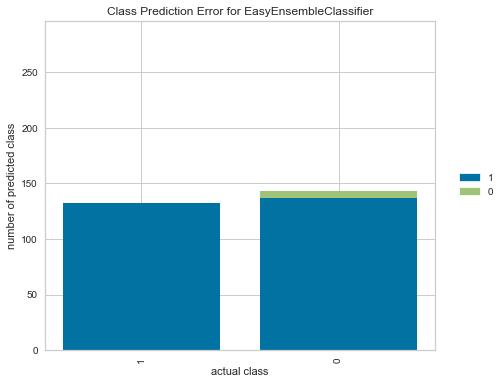

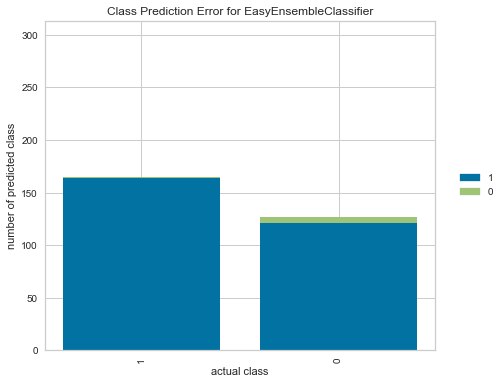

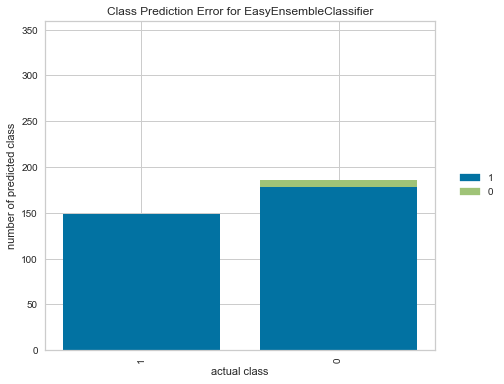

In [26]:
test_size = [0.16, 0.32, 0.34, 0.39]

for t in test_size:
    
    df = pd.read_csv('preprocessed_risk_factors_cervical_cancer.csv', usecols = features)
    X = df.drop('hinselmann', axis = 1) 
    y = df['hinselmann']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = t, random_state =0)
    
    from sklearn.preprocessing import StandardScaler
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)

    classes = [1, 0]

    from yellowbrick.classifier import ClassPredictionError
    visualizer = ClassPredictionError(EasyEnsembleClassifier(random_state = 25), classes=classes)

    # Fit the training data to the visualizer
    visualizer.fit(X_train, y_train)

    # Evaluate the model on the test data
    visualizer.score(X_test, y_test)

    # Draw visualization
    visualizer.show()

### We choose test_size  = 0.34

Recall Score: 0.8571
Macro Average of Recall Score: 0.7163
Weighted Average of Recall Score: 0.5822
------------------------------------------------------
Macro Average of Precision Score: 0.5206
Weighted Average of Precision Score: 0.9712
------------------------------------------------------
Macro Average of F1 Score: 0.4092
Weighted Average of F1 Score: 0.7136
---------------------------------------------------------------


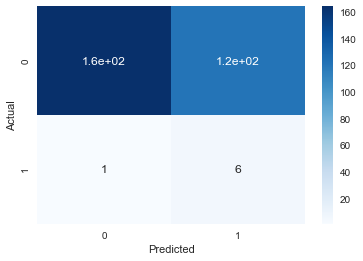

TP: 6, FP: 121, TN: 164, FN: 1
---------------------------------------------------------------
              precision    recall  f1-score   support

           0      0.994     0.575     0.729       285
           1      0.047     0.857     0.090         7

    accuracy                          0.582       292
   macro avg      0.521     0.716     0.409       292
weighted avg      0.971     0.582     0.714       292



In [27]:
df = pd.read_csv('preprocessed_risk_factors_cervical_cancer.csv', usecols = features)

X = df.drop('hinselmann', axis = 1) 
y = df['hinselmann']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.34, random_state =0)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

model = EasyEnsembleClassifier(random_state = 25)
model.fit(X_train, y_train)
y_hat = model.predict(X_test)

macro_weighted(y_test, y_hat)
cm()
class_rep()